In [26]:
import os
import glob
from hyperscreen import hypercore

In [52]:

from __future__ import division
from __future__ import print_function

import sys
import os

import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.io import fits
from astropy.table import Table

import pandas as pd
import numpy as np
np.seterr(divide='ignore')


class HRCevt1:
    '''
    A more robust HRC EVT1 file. Includes explicit
    columns for every status bit, as well as calculated
    columns for the f_p, f_b plane for your boomerangs.
    Check out that cool new filtering algorithm!
    '''

    def __init__(self, evt1file, verbose=False, as_astropy_table=False):

        # Do a standard read in of the EVT1 fits table
        self.filename = evt1file
        self.hdulist = fits.open(evt1file)
        self.data = Table(self.hdulist[1].data)
        self.header = self.hdulist[1].header
        self.gti = self.hdulist[2].data
        self.hdulist.close()  # Don't forget to close your fits file!

        fp_u, fb_u, fp_v, fb_v = self.calculate_fp_fb()

        self.gti.starts = self.gti['START']
        self.gti.stops = self.gti['STOP']

        self.gtimask = []
        # for start, stop in zip(self.gti.starts, self.gti.stops):
        #     self.gtimask = (self.data["time"] > start) & (self.data["time"] < stop)

        self.gtimask = (self.data["time"] > self.gti.starts[0]) & (
            self.data["time"] < self.gti.stops[-1])

        self.data["fp_u"] = fp_u
        self.data["fb_u"] = fb_u
        self.data["fp_v"] = fp_v
        self.data["fb_v"] = fb_v

        # Make individual status bit columns with legible names
        self.data["AV3 corrected for ringing"] = self.data["status"][:, 0]
        self.data["AU3 corrected for ringing"] = self.data["status"][:, 1]
        self.data["Event impacted by prior event (piled up)"] = self.data["status"][:, 2]
        # Bit 4 (Python 3) is spare
        self.data["Shifted event time"] = self.data["status"][:, 4]
        self.data["Event telemetered in NIL mode"] = self.data["status"][:, 5]
        self.data["V axis not triggered"] = self.data["status"][:, 6]
        self.data["U axis not triggered"] = self.data["status"][:, 7]
        self.data["V axis center blank event"] = self.data["status"][:, 8]
        self.data["U axis center blank event"] = self.data["status"][:, 9]
        self.data["V axis width exceeded"] = self.data["status"][:, 10]
        self.data["U axis width exceeded"] = self.data["status"][:, 11]
        self.data["Shield PMT active"] = self.data["status"][:, 12]
        # Bit 14 (Python 13) is hardware spare
        self.data["Upper level discriminator not exceeded"] = self.data["status"][:, 14]
        self.data["Lower level discriminator not exceeded"] = self.data["status"][:, 15]
        self.data["Event in bad region"] = self.data["status"][:, 16]
        self.data["Amp total on V or U = 0"] = self.data["status"][:, 17]
        self.data["Incorrect V center"] = self.data["status"][:, 18]
        self.data["Incorrect U center"] = self.data["status"][:, 19]
        self.data["PHA ratio test failed"] = self.data["status"][:, 20]
        self.data["Sum of 6 taps = 0"] = self.data["status"][:, 21]
        self.data["Grid ratio test failed"] = self.data["status"][:, 22]
        self.data["ADC sum on V or U = 0"] = self.data["status"][:, 23]
        self.data["PI exceeding 255"] = self.data["status"][:, 24]
        self.data["Event time tag is out of sequence"] = self.data["status"][:, 25]
        self.data["V amp flatness test failed"] = self.data["status"][:, 26]
        self.data["U amp flatness test failed"] = self.data["status"][:, 27]
        self.data["V amp saturation test failed"] = self.data["status"][:, 28]
        self.data["U amp saturation test failed"] = self.data["status"][:, 29]
        self.data["V hyperbolic test failed"] = self.data["status"][:, 30]
        self.data["U hyperbolic test failed"] = self.data["status"][:, 31]
        self.data["Hyperbola test passed"] = np.logical_not(np.logical_or(
            self.data['U hyperbolic test failed'], self.data['V hyperbolic test failed']))
        self.data["Hyperbola test failed"] = np.logical_or(
            self.data['U hyperbolic test failed'], self.data['V hyperbolic test failed'])

        self.obsid = self.header["OBS_ID"]
        self.obs_date = self.header["DATE"]
        self.target = self.header["OBJECT"]
        self.detector = self.header["DETNAM"]
        self.grating = self.header["GRATING"]
        self.exptime = self.header["EXPOSURE"]

        self.numevents = len(self.data["time"])
        self.goodtimeevents = len(self.data["time"][self.gtimask])
        self.badtimeevents = self.numevents - self.goodtimeevents

        self.hyperbola_passes = np.sum(np.logical_or(
            self.data['U hyperbolic test failed'], self.data['V hyperbolic test failed']))
        self.hyperbola_failures = np.sum(np.logical_not(np.logical_or(
            self.data['U hyperbolic test failed'], self.data['V hyperbolic test failed'])))

        if self.hyperbola_passes + self.hyperbola_failures != self.numevents:
            warnings.warn("Number of Hyperbola Test Failures and Passes ({}) does not equal total number of events ({}).".format(
                self.hyperbola_passes + self.hyperbola_failures, self.numevents))

        if as_astropy_table is False:
            # Multidimensional columns don't grok with Pandas
            self.data.remove_column('status')
            self.data = self.data.to_pandas()

        if verbose is True:
            if as_astropy_table is True:
                read_type = "Astropy Table"
            else:
                read_type = "Pandas DataFrame"
            print("HRC EVT1 file {} (ObsID {}, {}, {} ksec) initialized as new HRCevt1 {}. ".format(
                evt1file.split('/')[-1], self.obsid, self.target, self.detector, read_type))

    def __str__(self):
        return "HRC EVT1 object with {} events. Data is packaged as a Pandas Dataframe (or an Astropy Table if as_astropy_table=True on initialization.)".format(self.numevents)

    def calculate_fp_fb(self):
        '''
        Calculate the Fine Position (fp) and normalized central tap
        amplitude (fb) for the HRC U- and V- axes.

        Parameters
        ----------
        data : Astropy Table
            Table object made from an HRC evt1 event list. Must include the
            au1, au2, au3 and av1, av2, av3 columns.

        Returns
        -------
        fp_u, fb_u, fp_v, fb_v: float
            Calculated fine positions and normalized central tap amplitudes
            for the HRC U- and V- axes
        '''
        a_u = self.data["au1"]  # otherwise known as "a1"
        b_u = self.data["au2"]  # "a2"
        c_u = self.data["au3"]  # "a3"

        a_v = self.data["av1"]
        b_v = self.data["av2"]
        c_v = self.data["av3"]

        with np.errstate(invalid='ignore'):
            # Do the U axis
            fp_u = ((c_u - a_u) / (a_u + b_u + c_u))
            fb_u = b_u / (a_u + b_u + c_u)

            # Do the V axis
            fp_v = ((c_v - a_v) / (a_v + b_v + c_v))
            fb_v = b_v / (a_v + b_v + c_v)

        return fp_u, fb_u, fp_v, fb_v

    def threshold(self, img, bins):
        nozero_img = img.copy()
        nozero_img[img == 0] = np.nan

        # This is a really stupid way to threshold
        median = np.nanmedian(nozero_img)
        thresh = median * 5

        thresh_img = nozero_img
        # "If you don't ignore the warning, you'll get a warning" ~~ G. Tremblay
        with np.errstate(invalid='ignore'):
            thresh_img[thresh_img < thresh] = np.nan
        thresh_img[:int(bins[1] / 2), :] = np.nan
    #     thresh_img[:,int(bins[1]-5):] = np.nan
        return thresh_img

    def hyperscreen(self):
        '''
        Grant Tremblay's new algorithm. Screens events on a tap-by-tap basis.
        '''

        data = self.data

        #taprange = range(data['crsu'].min(), data['crsu'].max() + 1)
        taprange_u = range(data['crsu'].min() - 1, data['crsu'].max() + 1)
        taprange_v = range(data['crsv'].min() - 1, data['crsv'].max() + 1)

        bins = [200, 200]  # number of bins

        # Instantiate these empty dictionaries to hold our results
        u_axis_survivals = {}
        v_axis_survivals = {}

        for tap in taprange_u:
            # Do the U axis
            tapmask_u = data[data['crsu'] == tap].index.values
            if len(tapmask_u) < 2:
                continue
            keep_u = np.isfinite(data['fb_u'][tapmask_u])

            hist_u, xbounds_u, ybounds_u = np.histogram2d(
                data['fb_u'][tapmask_u][keep_u], data['fp_u'][tapmask_u][keep_u], bins=bins)
            thresh_hist_u = self.threshold(hist_u, bins=bins)

            posx_u = np.digitize(data['fb_u'][tapmask_u], xbounds_u)
            posy_u = np.digitize(data['fp_u'][tapmask_u], ybounds_u)
            hist_mask_u = (posx_u > 0) & (posx_u <= bins[0]) & (
                posy_u > -1) & (posy_u <= bins[1])

            # Values of the histogram where the points are
            hhsub_u = thresh_hist_u[posx_u[hist_mask_u] -
                                    1, posy_u[hist_mask_u] - 1]
            pass_fb_u = data['fb_u'][tapmask_u][hist_mask_u][np.isfinite(
                hhsub_u)]

            u_axis_survivals["U Axis Tap {:02d}".format(
                tap)] = pass_fb_u.index.values

        for tap in taprange_v:
            # Now do the V axis:
            tapmask_v = data[data['crsv'] == tap].index.values
            if len(tapmask_v) < 2:
                continue
            keep_v = np.isfinite(data['fb_v'][tapmask_v])

            hist_v, xbounds_v, ybounds_v = np.histogram2d(
                data['fb_v'][tapmask_v][keep_v], data['fp_v'][tapmask_v][keep_v], bins=bins)
            thresh_hist_v = self.threshold(hist_v, bins=bins)

            posx_v = np.digitize(data['fb_v'][tapmask_v], xbounds_v)
            posy_v = np.digitize(data['fp_v'][tapmask_v], ybounds_v)
            hist_mask_v = (posx_v > 0) & (posx_v <= bins[0]) & (
                posy_v > -1) & (posy_v <= bins[1])

            # Values of the histogram where the points are
            hhsub_v = thresh_hist_v[posx_v[hist_mask_v] -
                                    1, posy_v[hist_mask_v] - 1]
            pass_fb_v = data['fb_v'][tapmask_v][hist_mask_v][np.isfinite(
                hhsub_v)]

            v_axis_survivals["V Axis Tap {:02d}".format(
                tap)] = pass_fb_v.index.values

        # Done looping over taps

        u_all_survivals = np.concatenate(
            [x for x in u_axis_survivals.values()])
        v_all_survivals = np.concatenate(
            [x for x in v_axis_survivals.values()])

        # If the event passes both U- and V-axis tests, it survives
        all_survivals = np.intersect1d(u_all_survivals, v_all_survivals)
        survival_mask = np.isin(self.data.index.values, all_survivals)
        failure_mask = np.logical_not(survival_mask)

        num_survivals = sum(survival_mask)
        num_failures = sum(failure_mask)

        percent_tapscreen_rejected = round(
            ((num_failures / self.numevents) * 100), 2)

        # Do a sanity check to look for lost events. Shouldn't be any.
        if num_survivals + num_failures != self.numevents:
            print("WARNING: Total Number of survivals and failures does \
            not equal total events in the EVT1 file. Something is wrong!")

        legacy_hyperbola_test_survivals = sum(
            self.data['Hyperbola test passed'])
        legacy_hyperbola_test_failures = sum(
            self.data['Hyperbola test failed'])
        percent_legacy_hyperbola_test_rejected = round(
            ((legacy_hyperbola_test_failures / self.goodtimeevents) * 100), 2)

        percent_improvement_over_legacy_test = round(
            (percent_tapscreen_rejected - percent_legacy_hyperbola_test_rejected), 2)

        hyperscreen_results_dict = {"ObsID": self.obsid,
                                    "Target": self.target,
                                    "Exposure Time": self.exptime,
                                    "Detector": self.detector,
                                    "Number of Events": self.numevents,
                                    "Number of Good Time Events": self.goodtimeevents,
                                    "U Axis Survivals by Tap": u_axis_survivals,
                                    "V Axis Survivals by Tap": v_axis_survivals,
                                    "U Axis All Survivals": u_all_survivals,
                                    "V Axis All Survivals": v_all_survivals,
                                    "All Survivals (event indices)": all_survivals,
                                    "All Survivals (boolean mask)": survival_mask,
                                    "All Failures (boolean mask)": failure_mask,
                                    "Percent rejected by Tapscreen": percent_tapscreen_rejected,
                                    "Percent rejected by Hyperbola": percent_legacy_hyperbola_test_rejected,
                                    "Percent improvement": percent_improvement_over_legacy_test
                                    }

        return hyperscreen_results_dict

    def hyperbola(self, fb, a, b, h):
        '''Given the normalized central tap amplitude, a, b, and h,
        return an array of length len(fb) that gives a hyperbola.'''
        hyperbola = b * np.sqrt(((fb - h)**2 / a**2) - 1)

        return hyperbola

    def legacy_hyperbola_test(self, tolerance=0.035):
        '''
        Apply the hyperbolic test.
        '''

        # Remind the user what tolerance they're using
        # print("{0: <25}| Using tolerance = {1}".format(" ", tolerance))

        # Set hyperbolic coefficients, depending on whether this is HRC-I or -S
        if self.detector == "HRC-I":
            a_u = 0.3110
            b_u = 0.3030
            h_u = 1.0580

            a_v = 0.3050
            b_v = 0.2730
            h_v = 1.1
            # print("{0: <25}| Using HRC-I hyperbolic coefficients: ".format(" "))
            # print("{0: <25}|    Au={1}, Bu={2}, Hu={3}".format(" ", a_u, b_u, h_u))
            # print("{0: <25}|    Av={1}, Bv={2}, Hv={3}".format(" ", a_v, b_v, h_v))

        if self.detector == "HRC-S":
            a_u = 0.2706
            b_u = 0.2620
            h_u = 1.0180

            a_v = 0.2706
            b_v = 0.2480
            h_v = 1.0710
            # print("{0: <25}| Using HRC-S hyperbolic coefficients: ".format(" "))
            # print("{0: <25}|    Au={1}, Bu={2}, Hu={3}".format(" ", a_u, b_u, h_u))
            # print("{0: <25}|    Av={1}, Bv={2}, Hv={3}".format(" ", a_v, b_v, h_v))

        # Set the tolerance boundary ("width" of the hyperbolic region)

        h_u_lowerbound = h_u * (1 + tolerance)
        h_u_upperbound = h_u * (1 - tolerance)

        h_v_lowerbound = h_v * (1 + tolerance)
        h_v_upperbound = h_v * (1 - tolerance)

        # Compute the Hyperbolae
        with np.errstate(invalid='ignore'):
            zone_u_fit = self.hyperbola(self.data["fb_u"], a_u, b_u, h_u)
            zone_u_lowerbound = self.hyperbola(
                self.data["fb_u"], a_u, b_u, h_u_lowerbound)
            zone_u_upperbound = self.hyperbola(
                self.data["fb_u"], a_u, b_u, h_u_upperbound)

            zone_v_fit = self.hyperbola(self.data["fb_v"], a_v, b_v, h_v)
            zone_v_lowerbound = self.hyperbola(
                self.data["fb_v"], a_v, b_v, h_v_lowerbound)
            zone_v_upperbound = self.hyperbola(
                self.data["fb_v"], a_v, b_v, h_v_upperbound)

        zone_u = [zone_u_lowerbound, zone_u_upperbound]
        zone_v = [zone_v_lowerbound, zone_v_upperbound]

        # Apply the masks
        # print("{0: <25}| Hyperbolic masks for U and V axes computed".format(""))

        with np.errstate(invalid='ignore'):
            # print("{0: <25}| Creating U-axis mask".format(""), end=" |")
            between_u = np.logical_not(np.logical_and(
                self.data["fp_u"] < zone_u[1], self.data["fp_u"] > -1 * zone_u[1]))
            not_beyond_u = np.logical_and(
                self.data["fp_u"] < zone_u[0], self.data["fp_u"] > -1 * zone_u[0])
            condition_u_final = np.logical_and(between_u, not_beyond_u)

            # print(" Creating V-axis mask")
            between_v = np.logical_not(np.logical_and(
                self.data["fp_v"] < zone_v[1], self.data["fp_v"] > -1 * zone_v[1]))
            not_beyond_v = np.logical_and(
                self.data["fp_v"] < zone_v[0], self.data["fp_v"] > -1 * zone_v[0])
            condition_v_final = np.logical_and(between_v, not_beyond_v)

        mask_u = condition_u_final
        mask_v = condition_v_final

        hyperzones = {"zone_u_fit": zone_u_fit,
                      "zone_u_lowerbound": zone_u_lowerbound,
                      "zone_u_upperbound": zone_u_upperbound,
                      "zone_v_fit": zone_v_fit,
                      "zone_v_lowerbound": zone_v_lowerbound,
                      "zone_v_upperbound": zone_v_upperbound}

        hypermasks = {"mask_u": mask_u, "mask_v": mask_v}

        # print("{0: <25}| Hyperbolic masks created".format(""))
        # print("{0: <25}| ".format(""))
        return hyperzones, hypermasks

    def boomerang(self, mask=None, show=True, plot_legacy_zone=True, title=None, cmap=None, savepath=None, create_subplot=False, ax=None, rasterized=True):

        # You can plot the image on axes of a subplot by passing
        # that axis to this function. Here are some switches to enable that.

        if create_subplot is False:
            self.fig, self.ax = plt.subplots(figsize=(12, 8))
        elif create_subplot is True:
            if ax is None:
                self.ax = plt.gca()
            else:
                self.ax = ax

        if cmap is None:
            cmap = 'plasma'

        if mask is not None:
            self.ax.scatter(self.data['fb_u'], self.data['fp_u'],
                            c=self.data['sumamps'], cmap='bone', s=0.3, alpha=0.8, rasterized=rasterized)

            frame = self.ax.scatter(self.data['fb_u'][mask], self.data['fp_u'][mask],
                                    c=self.data['sumamps'][mask], cmap=cmap, s=0.5, rasterized=rasterized)

        else:
            frame = self.ax.scatter(self.data['fb_u'], self.data['fp_u'],
                                    c=self.data['sumamps'], cmap=cmap, s=0.5, rasterized=rasterized)

        if plot_legacy_zone is True:
            hyperzones, hypermasks = self.legacy_hyperbola_test(
                tolerance=0.035)
            self.ax.plot(self.data["fb_u"], hyperzones["zone_u_lowerbound"],
                         'o', markersize=0.3, color='black', alpha=0.8, rasterized=rasterized)
            self.ax.plot(self.data["fb_u"], -1 * hyperzones["zone_u_lowerbound"],
                         'o', markersize=0.3, color='black', alpha=0.8, rasterized=rasterized)

            self.ax.plot(self.data["fb_u"], hyperzones["zone_u_upperbound"],
                         'o', markersize=0.3, color='black', alpha=0.8, rasterized=rasterized)
            self.ax.plot(self.data["fb_u"], -1 * hyperzones["zone_u_upperbound"],
                         'o', markersize=0.3, color='black', alpha=0.8, rasterized=rasterized)

        self.ax.grid(False)

        if title is None:
            self.ax.set_title('{} | {} | ObsID {} | {} ksec | {} counts'.format(
                self.target, self.detector, self.obsid, round(self.exptime / 1000, 1), self.numevents))
        else:
            self.ax.set_title(title)

        self.ax.set_ylim(-1.1, 1.1)
        self.ax.set_xlim(-0.1, 1.1)

        self.ax.set_ylabel(r'Fine Position $f_p$ $(C-A)/(A + B + C)$')
        self.ax.set_xlabel(
            r'Normalized Central Tap Amplitude $f_b$ $B / (A+B+C)$')

        if create_subplot is False:
            self.cbar = plt.colorbar(frame, pad=-0.005)
            self.cbar.set_label("SUMAMPS")

        if show is True:
            plt.show()

        if savepath is not None:
            plt.savefig(savepath, dpi=150, bbox_inches='tight')
            print('Saved boomerang figure to: {}'.format(savepath))


    def image(self, masked_x=None, masked_y=None, xlim=None, ylim=None, detcoords=False, title=None, cmap=None, show=True, rasterized=True, savepath=None, create_subplot=False, ax=None):
        '''
        Create a quicklook image, in detector or sky coordinates, of the 
        observation. The image will be binned to 400x400. 
        '''

        # Create the 2D histogram
        nbins = (400, 400)

        if masked_x is not None and masked_y is not None:
            x = masked_x
            y = masked_y
            img_data, yedges, xedges = np.histogram2d(y, x, nbins)
        else:
            if detcoords is False:
                x = self.data['x'][self.gtimask]
                y = self.data['y'][self.gtimask]
            elif detcoords is True:
                x = self.data['detx'][self.gtimask]
                y = self.data['dety'][self.gtimask]
            img_data, yedges, xedges = np.histogram2d(y, x, nbins)

        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

        # Create the Figure
        styleplots()

        # You can plot the image on axes of a subplot by passing
        # that axis to this function. Here are some switches to enable that.
        if create_subplot is False:
            self.fig, self.ax = plt.subplots()
        elif create_subplot is True:
            if ax is None:
                self.ax = plt.gca()
            else:
                self.ax = ax

        self.ax.grid(False)

        if cmap is None:
            cmap = 'viridis'

        self.ax.imshow(img_data, extent=extent, norm=LogNorm(),
                       interpolation=None, rasterized=rasterized, cmap=cmap, origin='lower')

        if title is None:
            self.ax.set_title("ObsID {} | {} | {} | {:,} events".format(
                self.obsid, self.target, self.detector, self.goodtimeevents))
        else:
            self.ax.set_title("{}".format(title))
        if detcoords is False:
            self.ax.set_xlabel("Sky X")
            self.ax.set_ylabel("Sky Y")
        elif detcoords is True:
            self.ax.set_xlabel("Detector X")
            self.ax.set_ylabel("Detector Y")

        if xlim is not None:
            self.ax.set_xlim(xlim)
        if ylim is not None:
            self.ax.set_ylim(ylim)

        if show is True:
            plt.show(block=True)

        if savepath is not None:
            plt.savefig('{}'.format(savepath))
            print("Saved image to {}".format(savepath))



def styleplots(): # pragma: no cover

    mpl.rcParams['agg.path.chunksize'] = 10000

    # Make things pretty
    plt.style.use('ggplot')

    labelsizes = 10

    plt.rcParams['font.size'] = labelsizes
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['axes.labelsize'] = labelsizes
    plt.rcParams['xtick.labelsize'] = labelsizes
    plt.rcParams['ytick.labelsize'] = labelsizes



Errors happened on ObsIDs:

In [30]:
error_IDs = [18375, 1476, 5584, 19838, 4327]

In [34]:
error_files = []
for item in error_IDs:
    path = f'/Users/grant/Science/HRC_Database/EVT1_Files/{item}/secondary/'
    fitsfile = glob.glob(path + '*evt1*')[0]
    error_files.append(fitsfile)

In [35]:
error_files

['/Users/grant/Science/HRC_Database/EVT1_Files/18375/secondary/hrcf18375_000N001_evt1.fits.gz',
 '/Users/grant/Science/HRC_Database/EVT1_Files/1476/secondary/hrcf01476_000N004_evt1.fits.gz',
 '/Users/grant/Science/HRC_Database/EVT1_Files/5584/secondary/hrcf05584_000N003_evt1.fits.gz',
 '/Users/grant/Science/HRC_Database/EVT1_Files/19838/secondary/hrcf19838_001N001_evt1.fits.gz',
 '/Users/grant/Science/HRC_Database/EVT1_Files/4327/secondary/hrcf04327_000N003_evt1.fits.gz']

In [53]:
observations = {}
for obsid, item in zip(error_IDs, error_files):
    observations[f'{obsid}'] = HRCevt1(item)
    

In [54]:
observations

{'18375': <__main__.HRCevt1 at 0x7f91b8daa9d0>,
 '1476': <__main__.HRCevt1 at 0x7f91d2f0e150>,
 '5584': <__main__.HRCevt1 at 0x7f91e0c47e90>,
 '19838': <__main__.HRCevt1 at 0x7f91c1565110>,
 '4327': <__main__.HRCevt1 at 0x7f91c1571190>}

In [55]:
for item in observations: 
    print(observations[item].detector, round(observations[item].exptime/1000,2))

HRC-S 1.15
HRC-I 3.23
HRC-S 14.08
HRC-S 19.94
HRC-S 1.18


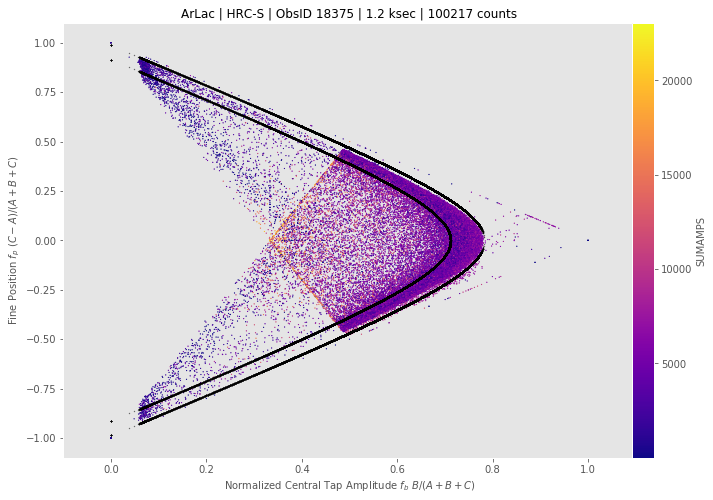

In [56]:
obs18375 = observations['18375']
obs18375.boomerang()

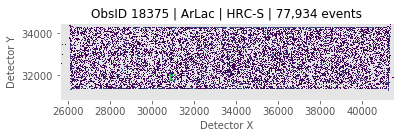

In [57]:
obs18375.image(detcoords=True)

In [50]:
obs18375.hyperscreen()

KeyError: 0